# Перенос стиля изображения

Основано на материалах https://pytorch.org/tutorials/advanced/neural_style_tutorial.html



***Идея алгоритма: признаки, полученные с помощью сверточной нейронной сети, можно использовать
для выделения содержательной и стилевой составляющих изображения.***

На вход алгоритму требуется три изображения:
* input-image - изменяемое входное изображение (обычно берется исходное изображение или белый шум)
* content-image - исходное изображение

* style-image - изображение, стиль которого будет использован


Алгоритм изменяет input-image таким образом, чтобы содержание было похоже на content-image, а стиль - на style-image.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import copy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Загрузка изображений

In [5]:
# !wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/VanGogh-starry_night.jpg/902px-VanGogh-starry_night.jpg

!wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn_2/screencast_1/cat.jpg

--2021-07-12 22:11:33--  https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/VanGogh-starry_night.jpg/902px-VanGogh-starry_night.jpg
Resolving upload.wikimedia.org... 2620:0:862:ed1a::2:b, 91.198.174.208
Connecting to upload.wikimedia.org|2620:0:862:ed1a::2:b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316794 (309K) [image/jpeg]
Saving to: '902px-VanGogh-starry_night.jpg.4'

902px-VanGogh-starr 100%[===================>] 309.37K  1.17MB/s    in 0.3s    

2021-07-12 22:11:33 (1.17 MB/s) - '902px-VanGogh-starry_night.jpg.4' saved [316794/316794]

--2021-07-12 22:11:33--  https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn_2/screencast_1/cat.jpg
Resolving raw.githubusercontent.com... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68324 (67K) [image/jpeg]
Saving to: 'cat.jpg.2'

cat.jpg.2           1

## Чтение и предобработка изображений

In [6]:
# зададим желаемый размер изображения
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([transforms.Resize([imsize,imsize]),  # меняем размер
                             transforms.ToTensor()])              # конвертируем в тензор

In [7]:
# загрузим изображения и предобработаем их
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [8]:
# cоздадим функцию, которая визуализирует изображение, копируя его и переводя обратно в PIL формат.
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)  
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [9]:
# читаем изображения
style_img = image_loader("902px-VanGogh-starry_night.jpg")
content_img = image_loader("cat.jpg")

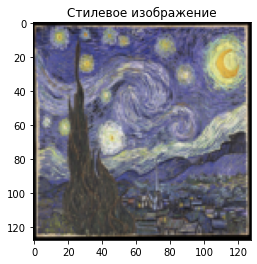

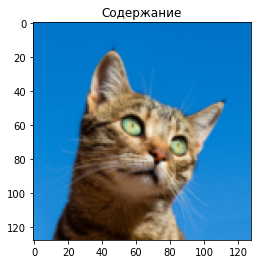

In [10]:
plt.figure()
imshow(style_img, title="Стилевое изображение")

plt.figure()
imshow(content_img, title="Содержание")

# Алгоритм

#### Функции потерь

In [11]:
# содержание
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [12]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [13]:
# стилевая функция потерь
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

#### Импорт модели предобученной на ImageNet

In [14]:
# загружаем модель
cnn = models.vgg19(pretrained=True).features.to(device).eval()

#### Модуль для нормализации входных изображений

In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std  = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std  = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

#### Берем сверточные слои для функции потерь

Напишем функцию, которая будет пропускать изображения через сверточные слои сети и использовать выходы из этих слоев для подсчета функции потерь

In [16]:
# слои содержания
content_layers_default = ['conv_4']
# слои для стиля
style_layers_default   = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [17]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # сопируем сеть
    cnn = copy.deepcopy(cnn)

    # нормализация изображений
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # контейнеры для функции потерь
    content_losses = []
    style_losses = []

    # составляем свою модель для подсчета функции потерь
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # добавляем слой
        model.add_module(name, layer)

        # считаем функцию потерь для содержания
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # считаем функцию потерь для стиля
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # отрезаем остальные слои
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss): break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

#### Перенос стиля градиентным спуском минимизируя функцию потерь

**При этом оптимизация тут идет по изображению, а не по весам сети!**

In [18]:
# выбор оптимизатора
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [19]:
style_weights = [1, 0.75, 0.2, 0.2, 0.2]

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    

    
    print('Загружаем модель')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, 
                                                                     normalization_mean, 
                                                                     normalization_std, 
                                                                     style_img, 
                                                                     content_img)
    
    print('Выбор оптимизатора')
    optimizer = get_input_optimizer(input_img)

    print('Оптимизация')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            
            model(input_img)
            
            style_score = 0
            content_score = 0

            # считаем функцию потерь по стилю
            for i, sl in enumerate(style_losses):
                style_score += style_weights[i] * sl.loss

            # считаем функцию потерь по содержанию
            for cl in content_losses:
                content_score += cl.loss

            # складываем функции потерь
            style_score   *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Запускаем алгоритм!

## Запуск алгоритма

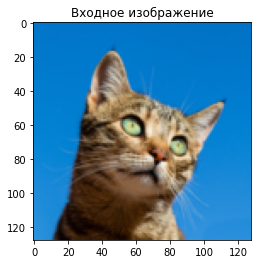

In [20]:
# входное изображение

input_img = content_img.clone() # инициализация контентом
#input_img = torch.randint_like(content_img, 0, 255) # инициализация шумом

plt.figure()
imshow(input_img, title='Входное изображение')

In [21]:
%%time
output = run_style_transfer(cnn,                       # предобученная сеть
                            cnn_normalization_mean,    # модуль для нормализации входных изображений
                            cnn_normalization_std,     # модуль для нормализации входных изображений
                            content_img,               # изображение с содержанием
                            style_img,                 # изображение со стилем
                            input_img,                 # входное изображение
                            style_weight=500000)

Загружаем модель
Выбор оптимизатора
Оптимизация
CPU times: user 1min 36s, sys: 11 s, total: 1min 47s
Wall time: 1min 45s


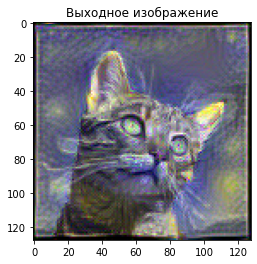

In [22]:
plt.figure()
imshow(output, title='Выходное изображение')

plt.ioff()
plt.show()